In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os, torch, pickle
from jarvis.utils import tqdm
from hexarena import DATA_DIR, STORE_DIR

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng()

# Policy identification using hidden Markov model

## Gather results of all trained HMMs

In [2]:
from hexarena.scripts.identify_policies import create_manager

subject, kappa, num_samples = 'marco', 0.1, 1000
z_dim, num_macros = 3, 10
manager = create_manager(subject, kappa, num_samples, z_dim=z_dim, num_macros=num_macros)

Collect data:   0%|                                                                                           …

In [3]:
from hexarena.scripts.identify_policies import e_step

knowns, beliefs, actions = manager.knowns, manager.beliefs, manager.actions

keys, lls_full, metrics = [], {}, {}
for key, config in tqdm(list(manager.completed(min_epoch=40, cond={'z_dim': z_dim, 'kappa': kappa}))):
    keys.append(key)
    manager.setup(config)
    manager.load_ckpt(manager.ckpts[key])

    lls_full[key] = []
    hmp = manager.hmp
    log_gammas, _, _ = e_step(hmp, knowns, beliefs, actions)
    for i in range(manager.num_blocks):
        gammas = log_gammas[i].exp()
        with torch.no_grad():
            inputs = hmp.policy_inputs(knowns[i].to(hmp.device), beliefs[i].to(hmp.device))
            _, logps = hmp.action_probs(inputs)
            lls_full[key].append((hmp.emission_probs(logps, actions[i])*gammas).sum(dim=1).cpu())

    ll = manager.ckpts[key]['ll_test']
    log_pi = manager.hmp.log_pi.clone()
    for _ in range(20): # equilibrium distribution
        log_pi = torch.stack([torch.logsumexp(manager.hmp.log_A[:, i]+log_pi, dim=0) for i in range(manager.hmp.num_policies)])
    ent = -(log_pi.exp()*log_pi).sum().item()
    p_dwell = (manager.hmp.log_A.diag()+log_pi).exp().sum().item()
    if p_dwell>3:
        raise

    metrics[key] = (ll, ent, p_dwell)

  0%|                                                                                                         …

## Filter out only good solutions

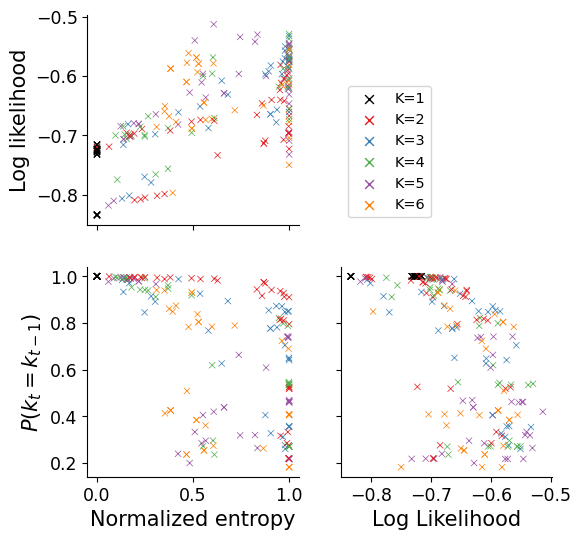

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
palette = np.stack([(0, 0, 0), *mpl.colormaps['Set1'].colors[:5]])
lls, ents, ps_dwell = [], [], []
colors = []

k_min, k_max = 1, 7
for num_policies in range(k_min, k_max):
    _lls, _ents, _ps_dwell = np.array([
        metrics[key] for key in keys if manager.configs[key].num_policies==num_policies
    ]).T
    if num_policies>1:
        _ents /= np.log(num_policies)
    lls.append(_lls); ents.append(_ents); ps_dwell.append(_ps_dwell)
    colors.append(np.tile(palette[num_policies-1][None], (len(_lls), 1)))
lls = np.concatenate(lls); ents = np.concatenate(ents); ps_dwell = np.concatenate(ps_dwell)
colors = np.concatenate(colors)
idxs = rng.permutation(len(lls))
lls = lls[idxs]; ents = ents[idxs]; ps_dwell = ps_dwell[idxs]; colors = colors[idxs]

for i, ax in enumerate(axes.ravel()):
    if i==0:
        xs = ents; xlabel = ''
        ys = lls; ylabel = 'Log likelihood'
    if i==1:
        continue
    if i==2:
        xs = ents; xlabel = 'Normalized entropy'
        ys = ps_dwell; ylabel = '$P(k_t=k_{t-1})$'
    if i==3:
        xs = lls; xlabel = 'Log Likelihood'
        ys = ps_dwell; ylabel = ''
    ax.scatter(xs, ys, c=colors, marker='x', s=20, linewidth=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
ax = axes[0, 1]; hs = []
for num_policies in range(k_min, k_max):
    hs.append(ax.scatter([], [], marker='x', s=40, linewidth=1, color=palette[num_policies-1]))
ax.legend(hs, [f'K={k}' for k in range(k_min, k_max)], loc='lower left', fontsize='x-small')
ax.axis('off')
axes[0, 0].set_xticklabels([])
axes[1, 1].set_yticklabels([])
fig.savefig(FIG_DIR/f'HMP.comparison_[{subject}][kappa{kappa}].svg')

In [104]:
keys_good = {}
for num_policies in range(k_min, k_max):
    keys_good[num_policies] = []
    for key in keys:
        if manager.configs[key].num_policies==num_policies:
            ll, ent, p_dwell = metrics[key]
            if ll>-0.75 and (num_policies==1 or ent/np.log(num_policies)>0.8) and p_dwell>0.95**num_policies:
                keys_good[num_policies].append(key)

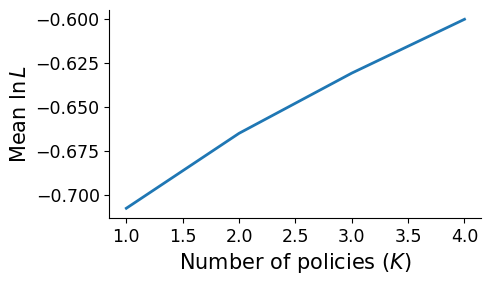

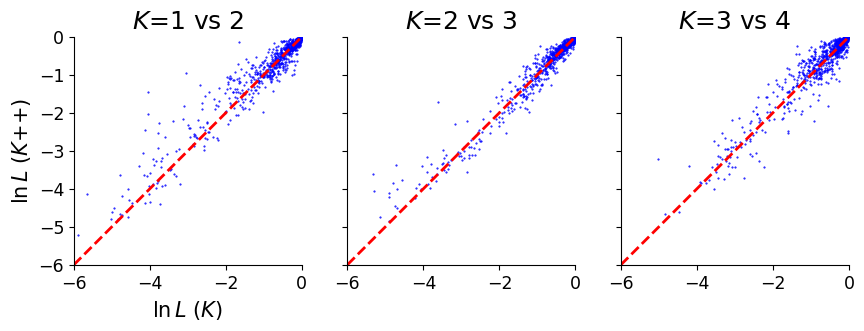

In [106]:
k_min, k_max = 1, 5
lls = {}
for num_policies in range(k_min, k_max):
    lls[num_policies] = []
    for i in range(manager.num_blocks):
        lls[num_policies].append(torch.stack([lls_full[key][i] for key in keys_good[num_policies]]).mean(dim=0))
    lls[num_policies] = torch.cat(lls[num_policies])

_, ax = plt.subplots()
ax.plot(np.arange(k_min, k_max), [lls[k].mean() for k in range(k_min, k_max)])
# ax.boxplot([lls[k] for k in range(k_min, k_max)], sym='')
ax.set_xlabel('Number of policies ($K$)')
ax.set_ylabel(r'Mean $\ln L$')
plt.show()

_, axes = plt.subplots(1, k_max-k_min-1, figsize=(10, 3))
l_lim = (-6, 0)
# l_lim = (0, 1)
for k, ax in enumerate(axes, 1):
    idxs = rng.choice(len(lls[k]), 1000, replace=False)
    ax.scatter(lls[k][idxs], lls[k+1][idxs], s=1, marker='.', color='blue')
    ax.plot(l_lim, l_lim, color='red', linewidth=2, linestyle='--', zorder=1)
    ax.set_xlim(l_lim)
    ax.set_ylim(l_lim)
    ax.set_aspect('equal')
    ax.set_title(f'$K$={k} vs {k+1}')
    # ax.set_xlabel(r'$\ln L$'+f' ($K$={k})')
    if k>1:
        ax.set_yticklabels([])
ax = axes[0]
ax.set_xlabel(r'$\ln L$ ($K$)')
ax.set_ylabel(r'$\ln L$ ($K$++)')
# ax.set_ylabel(r'$\ln L$ (K+=1)')
plt.show()

## Perform clustering for solutions with the same number of policies

# Visualize HMM solution

## HMM iteration

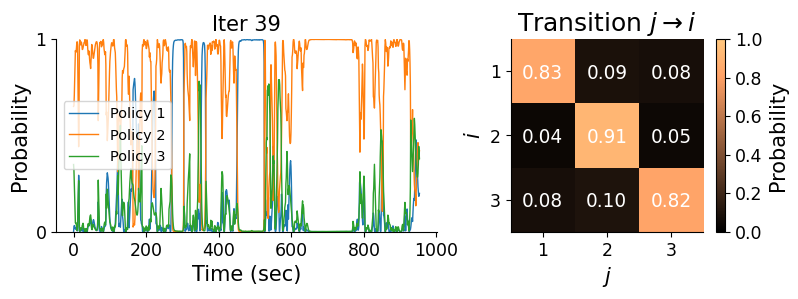

In [112]:
num_policies = 3
key = rng.choice(keys_good[num_policies]).item()

key = 'B74F2BEF'

manager.setup(manager.configs[key])
manager.load_ckpt(manager.ckpts[key])

block_idx = rng.choice(manager.num_blocks)
# block_idx = 15
gammas = torch.stack(manager.gammas[block_idx])
As = torch.stack(manager.As).numpy()
N = num_policies

fig, axes = plt.subplots(1, 2, figsize=(9, 2.5), gridspec_kw={'width_ratios': [1.5, 1]})
ax = axes[0]
h_gammas = ax.plot(gammas[0], linewidth=1)
h_title = ax.set_title('', fontsize='medium')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.legend(h_gammas, [f'Policy {i+1}' for i in range(N)], loc='center left', fontsize='x-small')
ax = axes[1]
h_A = ax.imshow(As[0], vmin=0, vmax=1, extent=[0.5, N+0.5, N+0.5, 0.5], cmap='copper')
h_probs = np.empty((N, N), dtype=object)
for i in range(N):
    for j in range(N):
        h_probs[i, j] = ax.text(
            j+1, i+1, '{:.2f}'.format(As[0, i, j]), ha='center', va='center_baseline',
            color='white', fontsize=40/N,
        )
ax.set_xlim([0.5, N+0.5]), ax.set_ylim([N+0.5, 0.5])
ax.set_xticks(np.arange(N)+1), ax.set_yticks(np.arange(N)+1)
ax.set_title(r'Transition $j \rightarrow i$')
ax.set_xlabel('$j$'), ax.set_ylabel('$i$')
plt.colorbar(
    h_A, ax=ax, shrink=1, label='Probability',
)

def update(t):
    for i in range(num_policies):
        h_gammas[i].set_ydata(gammas[t, :, i])
    h_A.set_data(As[t])
    h_title.set_text(f'Iter {t}')
    for i in range(N):
        for j in range(N):
            h_probs[i, j].set_text('{:.2f}'.format(As[t, i, j]))
    return *h_gammas, h_A, h_title, *h_probs.flatten()

ani = FuncAnimation(
    fig, update, frames=range(len(gammas)), blit=False,
)

# HTML(ani.to_jshtml())
# savename = 'EM.iteration_{}[block{:02d}]_[Np{}]'.format(subject, block_idx, num_policies)
savename = 'EM.iteration_{}[block{:02d}]_[Np{}]_{}'.format(subject, block_idx, num_policies, key)
ani.save(FIG_DIR/f'{savename}.mp4', dpi=200)
fig.savefig(FIG_DIR/f'{savename}.svg')
plt.show()

## Visualizing policies

In [32]:
from identify_policies import e_step

hmp = manager.hmp
knowns = torch.cat(manager.knowns)
beliefs = torch.cat(manager.beliefs)
actions = torch.cat(manager.actions)
log_gammas, _, _ = e_step(manager.hmp, manager.knowns, manager.beliefs, manager.actions)
gammas = torch.cat([log_gammas[i].exp() for i in range(len(log_gammas))]).mean(dim=0)

with torch.no_grad():
    zs = hmp.compress_beliefs(beliefs)
    inputs = hmp.policy_inputs(knowns, beliefs)
    _, logps = hmp.action_probs(inputs)
    deltas = hmp.emission_probs(logps, actions).std(dim=1)

with open('store/belief.proj_3D.pkl', 'rb') as f:
    w_rot = pickle.load(f)
zs = np.matmul(zs, w_rot)

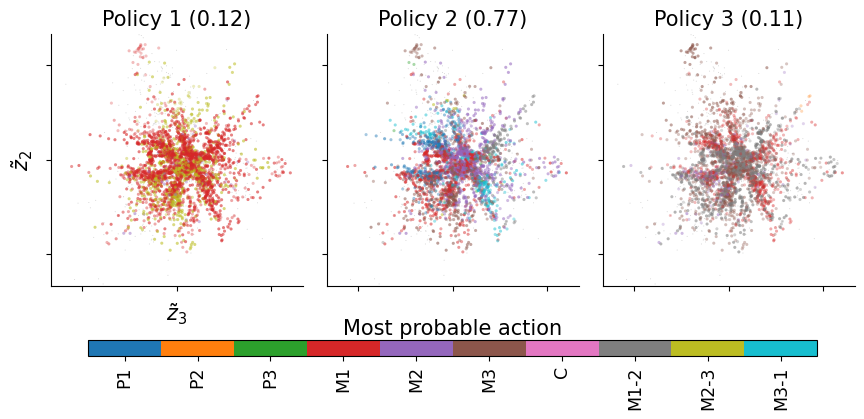

In [33]:
palette = plt.get_cmap('tab10').colors

fig = plt.figure(figsize=(3*num_policies, 4))
assert np.array(palette).shape==(num_macros, 3)
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/num_policies
axes, artists = [], []
c_scale = logps.max().exp()
idxs = np.argsort(deltas.numpy())[-3000:]
rng.shuffle(idxs)
idxs_base = rng.choice(len(zs), 1000)
for k in range(num_policies):
    _, a_idxs = logps[idxs, k].max(dim=1)
    cs = []
    for i, a_idx in enumerate(a_idxs):
        alpha = logps[idxs[i], k, a_idx].exp().item()/c_scale*0.4+0.2
        cs.append((*palette[a_idx], alpha))
    cs = np.array(cs)

    ax = fig.add_axes([margin+(width+gap)*k, 0.05, width, 0.9])
    ax.scatter(zs[idxs_base, 2], zs[idxs_base, 1], s=0.5, c='lightgray', edgecolor='none', zorder=-1)
    ax.scatter(zs[idxs, 2], zs[idxs, 1], s=5, c=cs, edgecolor='none')
    ax_lim = [-4, 4]
    ax.set_xlim(ax_lim), ax.set_ylim(ax_lim)
    ax.set_aspect('equal')
    ax_ticks = [-3, 0, 3]
    ax.set_xticks(ax_ticks), ax.set_yticks(ax_ticks)
    ax.set_xticklabels([]), ax.set_yticklabels([])
    if k==0:
        ax.set_xlabel(r'$\tilde{z}_3$'), ax.set_ylabel(r'$\tilde{z}_2$')
    ax.set_title('Policy {} ({:.2f})'.format(k+1, gammas[k]), fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), ax=axes,
    orientation='horizontal', shrink=.9, aspect=15*num_policies, pad=0.15,
    label='Most probable action',
)
cbar.ax.set_xticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_xticklabels([
    'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'C', 'M1-2', 'M2-3', 'M3-1',
], rotation=90)
cbar.ax.xaxis.set_label_position('top')
fig.savefig(FIG_DIR/f'{subject}_policy.on.2d.belief_[{num_policies}policy].svg')

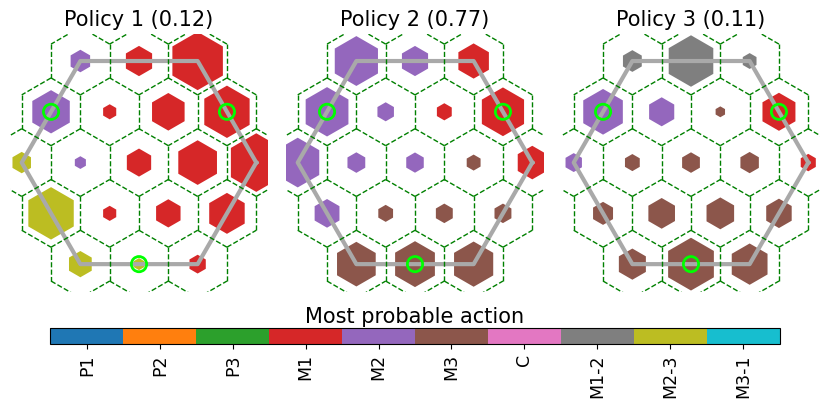

In [34]:
num_tiles = env.arena.num_tiles
probs = np.empty((num_policies, num_tiles, num_macros))
for k in range(num_policies):
    for pos in range(num_tiles):
        idxs = knowns[:, 0].numpy().astype(int)==pos
        probs[k, pos] = logps[idxs, k].exp().mean(dim=0).numpy()

fig = plt.figure(figsize=(3*num_policies, 4))
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/num_policies
axes = []
for k in range(num_policies):
    ax = fig.add_axes([margin+(width+gap)*k, 0.05, width, 0.9])
    env.arena.plot_mesh(ax)
    for pos in range(num_tiles):
        a_idx = np.argmax(probs[k, pos])
        # color = (*palette[a_idx], probs[k, pos, a_idx])
        env.arena.plot_tile(ax, pos, color=palette[a_idx], size=probs[k, pos, a_idx]/probs.max())
    ax.set_title('Policy {} ({:.2f})'.format(k+1, gammas[k]), fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), ax=axes,
    orientation='horizontal', shrink=.9, aspect=15*num_policies, pad=0.1,
    label='Most probable action',
)
cbar.ax.set_xticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_xticklabels([
    'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'C', 'M1-2', 'M2-3', 'M3-1',
], rotation=90)
cbar.ax.xaxis.set_label_position('top')
plt.show()
fig.savefig(FIG_DIR/f'{subject}_policy.on.arena_[{num_policies}policy].svg')

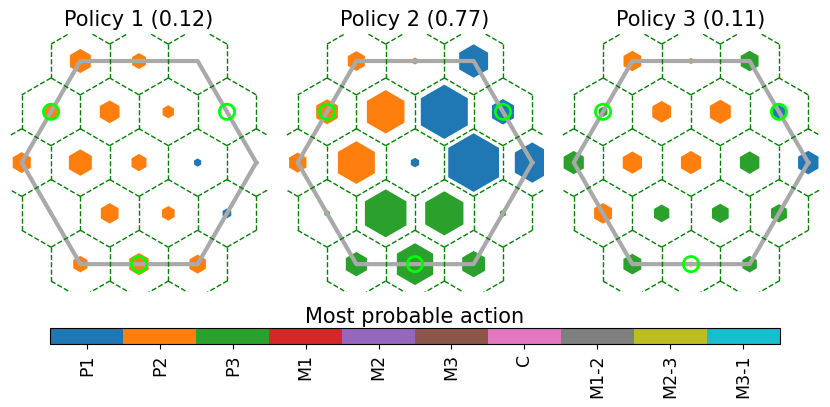

In [35]:
num_tiles = env.arena.num_tiles
probs = np.empty((num_policies, num_tiles, num_macros))
for k in range(num_policies):
    for pos in range(num_tiles):
        idxs = knowns[:, 0].numpy().astype(int)==pos
        probs[k, pos] = logps[idxs, k].exp().mean(dim=0).numpy()
probs[..., 3:] = 0.

fig = plt.figure(figsize=(3*num_policies, 4))
margin, gap = 0.05, 0.02
width = (1-2*margin-2*gap)/num_policies
axes = []
for k in range(num_policies):
    ax = fig.add_axes([margin+(width+gap)*k, 0.05, width, 0.9])
    env.arena.plot_mesh(ax)
    for pos in range(num_tiles):
        a_idx = np.argmax(probs[k, pos])
        # color = (*palette[a_idx], probs[k, pos, a_idx])
        env.arena.plot_tile(ax, pos, color=palette[a_idx], size=probs[k, pos, a_idx]/probs.max())
    ax.set_title('Policy {} ({:.2f})'.format(k+1, gammas[k]), fontsize='medium')
    axes.append(ax)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(cmap='tab10'), ax=axes,
    orientation='horizontal', shrink=.9, aspect=15*num_policies, pad=0.1,
    label='Most probable action',
)
cbar.ax.set_xticks((np.arange(num_macros)+0.5)/num_macros)
cbar.ax.set_xticklabels([
    'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'C', 'M1-2', 'M2-3', 'M3-1',
], rotation=90)
cbar.ax.xaxis.set_label_position('top')
plt.show()